In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('ggplot')

idx = pd.IndexSlice

In [2]:
root = Path.cwd().parent.parent.parent / "cluster_data"

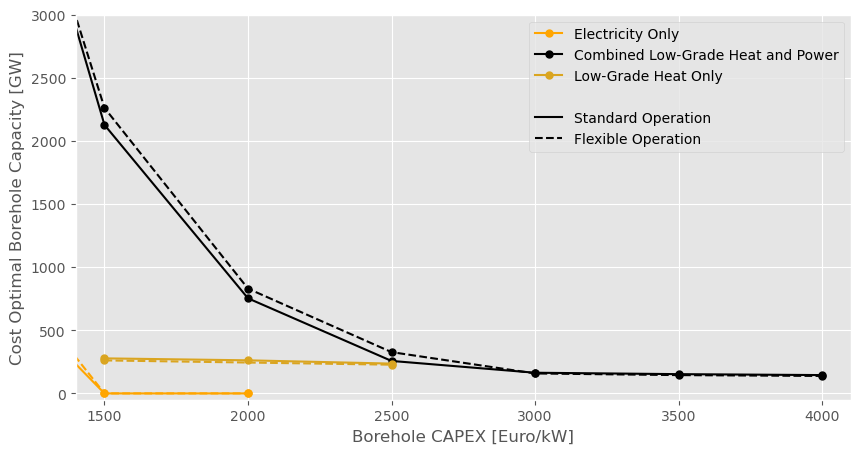

In [4]:
def get_data(mode, op):

    if mode == "chp" or mode == "dh":
        df = pd.read_csv(
            root / f"{mode}_data" / 
            f"csvs_{op}" / 
            "nodal_capacities.csv", 
            index_col=[0,1,2], 
            header=[0,1,2,3,4,5,6]
            )
    elif mode == "elec":
        df = pd.read_csv(root / f"{mode}_data" / "csvs" / "nodal_capacities.csv", index_col=[0,1,2], header=[0,1,2,3,4,5,6])


    df = df.groupby(level=[0,2]).sum()
    df.columns = df.columns.droplevel([0,1,2,3,5])

    df["carrier"] = df.index.get_level_values(1)
    df.index = df.index.droplevel(1)

    df.index += " " + df.carrier

    df = df.loc[df.carrier.isin(["geothermal heat", "geothermal heat elec"])]
    df.drop("carrier", axis=1, inplace=True)
    df = df.loc[:, idx[:, op]]
    df.columns = df.columns.droplevel(1)

    return df.loc["links geothermal heat"].mul(0.5).mul(1e-3)

elec_static = get_data("elec", "static")
elec_flex = get_data("elec", "flex")
chp_static = get_data("chp", "static")
chp_flex = get_data("chp", "flex")
dh_static = get_data("dh", "static")
dh_flex = get_data("dh", "flex")

fig, ax = plt.subplots(figsize=(10, 5))

# elec_static.plot.(ax=ax, stacked=True, width=0.8, edgecolor='black', linewidth=0.5)

labels = {
    # "elec static": "Electricity Only, Inflexible Operation",
    "elec static": "Electricity Only",
    "elec flex": "Electricity Only, Operation with Storage",
    # "chp static": "Combined Heat and Power, Inflexible Operation",
    "chp static": "Combined Low-Grade Heat and Power",
    "chp flex": "Combined Heat and Power, Operation with Storage",
    # "dh static": "District Heating, Inflexible Operation",
    "dh static": "Low-Grade Heat Only",
    "dh flex": "District Heating, Operation with Storage",
}

line_kwargs = {
    "marker": 'o',
    "markersize": 5,
}

ax.plot(elec_static.index.astype(int), elec_static.values, color="orange", label=labels["elec static"], **line_kwargs)
ax.plot(elec_flex.index.astype(int), elec_flex.values, color="orange", linestyle="--", **line_kwargs)
ax.plot(chp_static.index.astype(int), chp_static.values, color="k", label=labels["chp static"], **line_kwargs)
ax.plot(chp_flex.index.astype(int), chp_flex.values, color="k", linestyle="--", **line_kwargs)
ax.plot(dh_static.index.astype(int), dh_static.values, color="goldenrod", label=labels["dh static"], **line_kwargs)
ax.plot(dh_flex.index.astype(int), dh_flex.values, color="goldenrod", linestyle="--", **line_kwargs)

handles = ax.get_legend_handles_labels()
handles = (
    handles[0] + [
    Line2D([0], [0], color='white', lw=0, label=''),
    Line2D([0], [0], color='k', lw=1.5, label='Standard Operation'),
    Line2D([0], [0], color='k', lw=1.5, linestyle="--", label='Flexible Operation'),
    ]
)

ax.legend(handles=handles)

ax.set_ylim(-50, 3000)
ax.set_xlim(1400, 4100)

ax.set_ylabel("Cost Optimal Borehole Capacity [GW]")
ax.set_xlabel("Borehole CAPEX [Euro/kW]")

plt.savefig("main_plot.pdf")

plt.show()